In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
/*Disable scrollbar in a cell*/

<IPython.core.display.Javascript object>

In [11]:
import shap
import SALib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import multiprocessing as mp
import matplotlib.pyplot as plt

from tqdm import tqdm
from SALib.sample import saltelli
from SALib.analyze import sobol, delta
from itertools import combinations, product
from sklearn.preprocessing import PolynomialFeatures

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


# Load data
name = 'gsa-7pars-fine'
path_to_frame = f'../experiments/{name}/'
# frame = pd.read_pickle(f"{path_to_frame}{name}.pkl")
segregation_data = pd.read_pickle(f"{path_to_frame}data/frame.pkl")

# Format data
# Construct a dictionary of name (key) and title for plots (value)
names_bounds = {'single_utility_at_max': 'Utility at max',
                'single_optimal_fraction': 'Optimal fraction', 
                'radius': 'Radius', 
                'neighbourhood_mixture': 'Neighbourhood perception',
                'alpha': 'Alpha', 
                'school_capacity': 'School capacity',
                'dummy':'Noise'}

# Construct lists of input columns and outputs to plot
columns_to_plot = list(names_bounds.values())
outcomes = {'res_seg_new': 'Residential Segregation (Theil)',
            'school_seg_new': 'School Segregation (Theil)'}
outcomes_to_plot = list(outcomes.values())

# Rename the columns
segregation_data.rename(columns=names_bounds, inplace=True)
segregation_data.rename(columns=outcomes, inplace=True)
if 'res_seg' in segregation_data.columns:
    segregation_data.drop(['res_seg', 'school_seg'], axis=1, inplace=True)
segregation_data['Difference in Segregation'] = \
    segregation_data['School Segregation (Theil)'] - \
    segregation_data['Residential Segregation (Theil)']
outcomes_to_plot += ['Difference in Segregation']

# XGBoost

In [12]:
np.random.seed(0)
X = segregation_data[columns_to_plot]
outcome = 'Residential Segregation (Theil)'
Y = segregation_data[outcome]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
DM_train = xgb.DMatrix(data = X_train, label = Y_train) 
DM_test =  xgb.DMatrix(data = X_test, label = Y_test)

model = xgb.train({'eta':1, 'max_depth':5, 'base_score': 0, "lambda": 0}, DM_train, 100)
pred = model.predict(DM_test)
print("Root mean square error for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(Y_test, pred)), 2)))
print("R^2 for test dataset: {}".format(r2_score(Y_test, pred)))

Root mean square error for test dataset: 0.11
R^2 for test dataset: 0.931858957730858


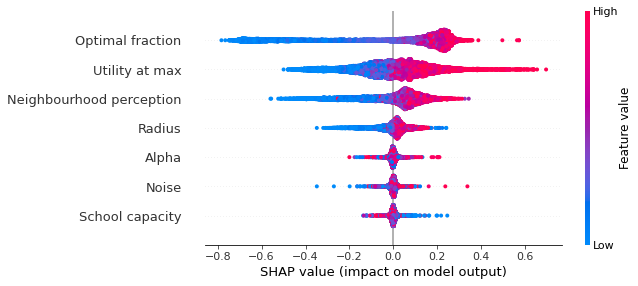

In [13]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
# np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()
shap.summary_plot(shap_values, X_train)

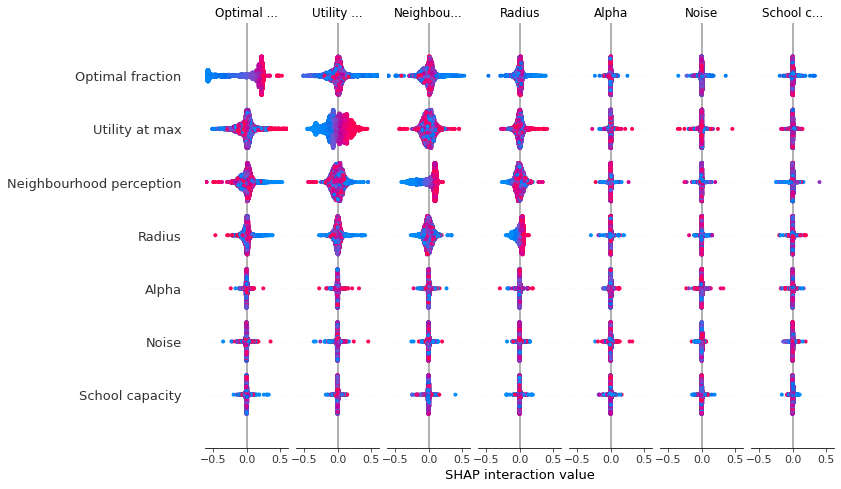

In [14]:
shap_interaction_values = explainer.shap_interaction_values(X_train)
shap.summary_plot(shap_interaction_values, X_train)

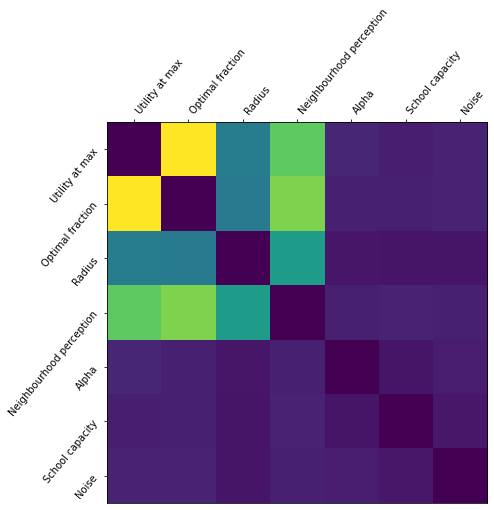

In [15]:
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0

plt.figure(figsize=(7,7))
plt.imshow(tmp, cmap='viridis')
plt.yticks(range(tmp.shape[0]), X_train.columns, rotation=50.4, horizontalalignment="right")
plt.xticks(range(tmp.shape[0]), X_train.columns, rotation=50.4, horizontalalignment="left")
plt.gca().xaxis.tick_top()
plt.show()


('Optimal fraction', 'Alpha')


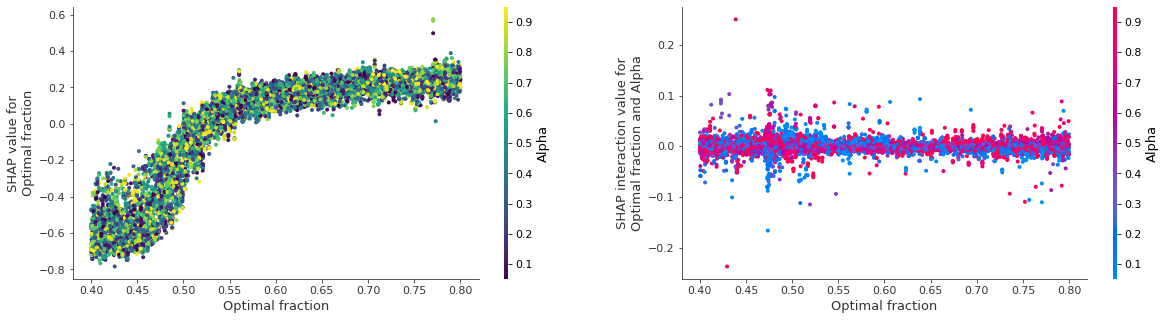

('Optimal fraction', 'Utility at max')


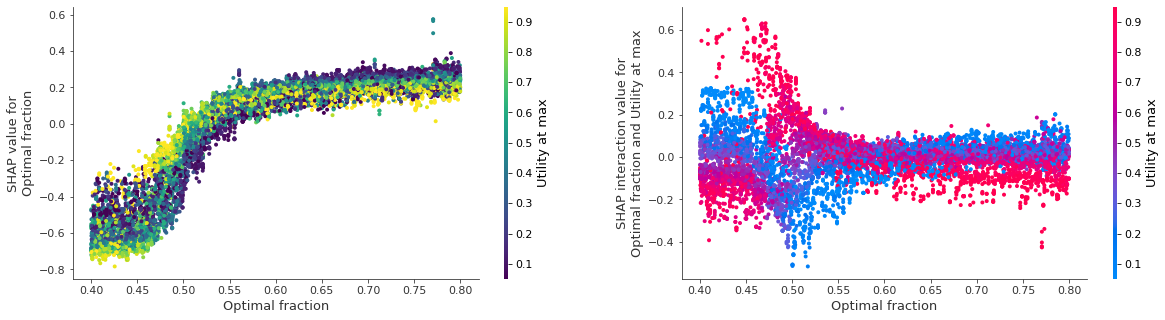

('Optimal fraction', 'Radius')


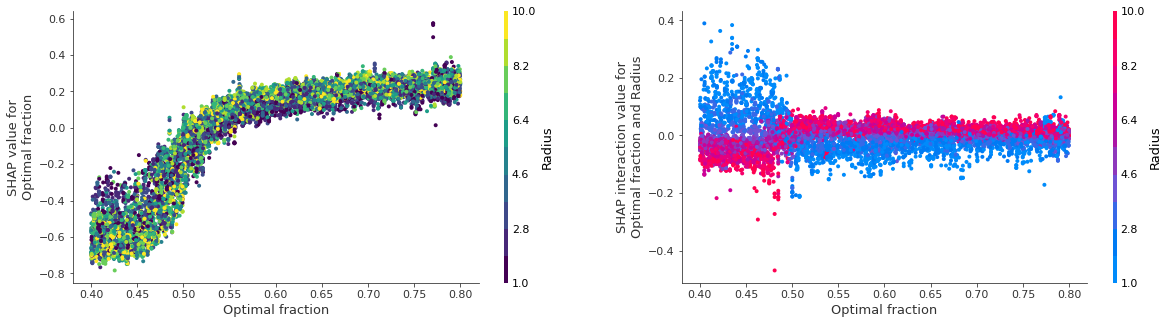

('Optimal fraction', 'Neighbourhood perception')


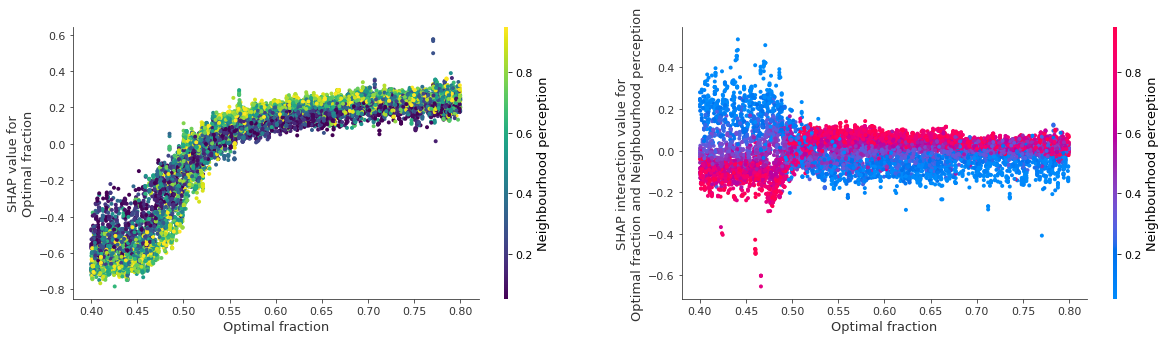

('Alpha', 'Utility at max')


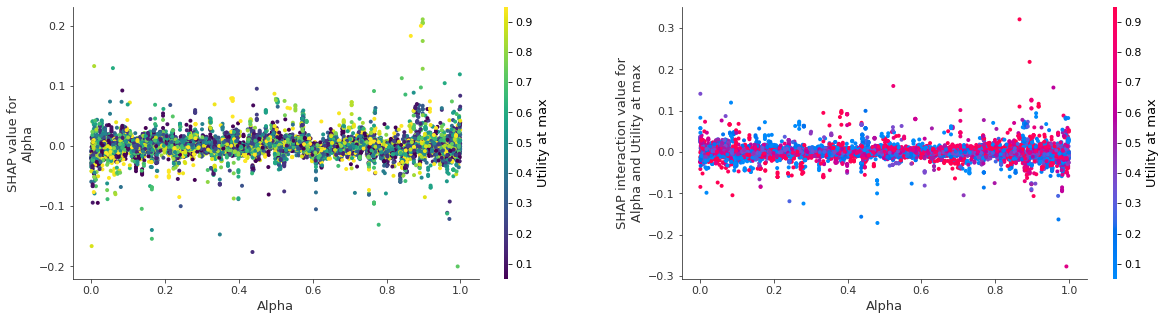

('Alpha', 'Radius')


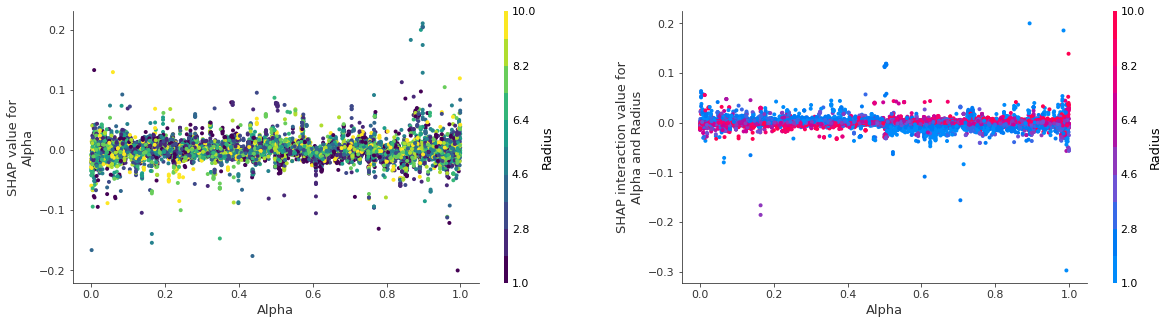

('Alpha', 'Neighbourhood perception')


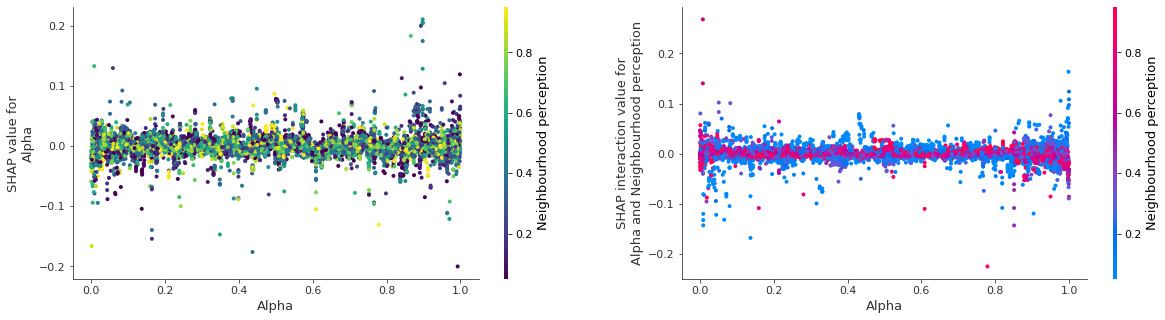

('Utility at max', 'Radius')


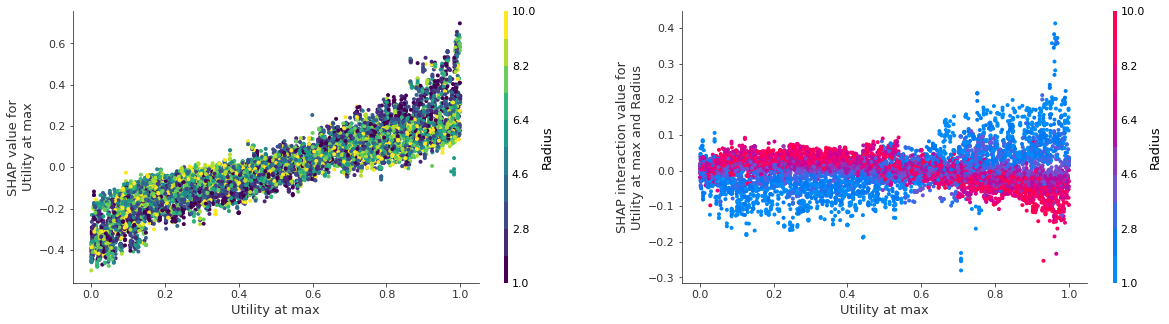

('Utility at max', 'Neighbourhood perception')


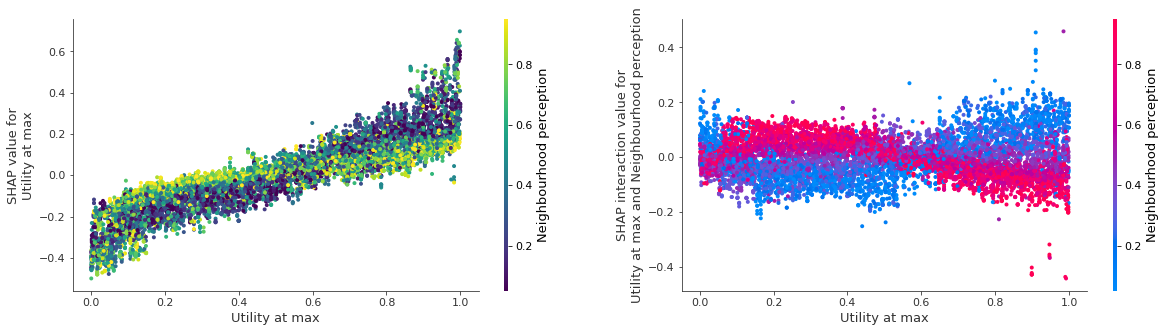

('Radius', 'Neighbourhood perception')


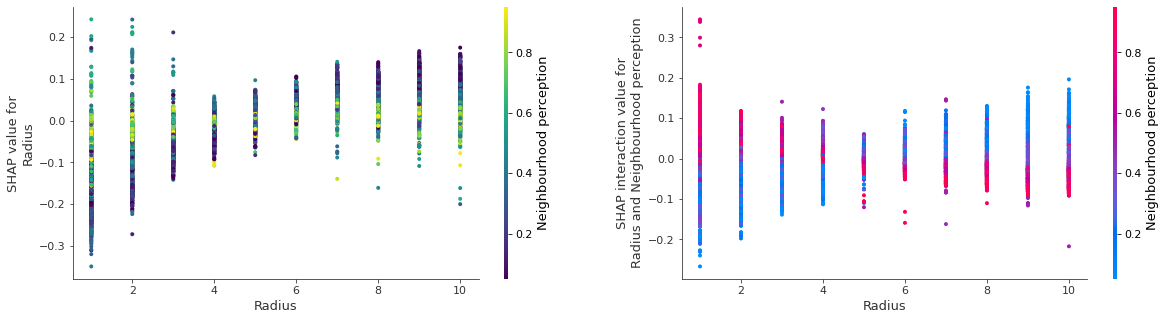

In [16]:
subset = [names_bounds[name] for name in ['single_optimal_fraction', 
            'alpha', 'single_utility_at_max', 'radius', 'neighbourhood_mixture']]
interactions = combinations(subset, 2)
vmax = max([segregation_data[outcome].max() for outcome in outcomes_to_plot])
for names in interactions:
    print(names)
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    axs = axs.flatten()
    shap.dependence_plot(names[0], shap_values, X_train, 
                            interaction_index=names[1], ax=axs[0], 
                             show=False, cmap=plt.get_cmap("viridis"))
    shap.dependence_plot(names, shap_interaction_values, X_train, 
                             ax=axs[1], show=False, 
                             cmap=plt.get_cmap("viridis"))
    plt.show()


# Archive

In [ ]:
# reduced = melted[np.isclose(melted.radius, 1, 0.01) | np.isclose(melted.radius, 3, 0.01)]

# Plot
# sns.set_theme(style='white', font_scale=2)
# plot = sns.relplot(data=melted, 
#                     x="single_optimal_fraction", 
#                     y="segregation_index", 
#                     hue="segregation_type",
#                     style="radius",
#                     col="single_category_thresholds", 
#                     row="homophily_std", 
#                     kind="scatter", 
#                     facet_kws={'margin_titles':True,
#                               'legend_out':False})
# plot.set_titles(row_template="Tolerance Std.: {row_name:.2f}", 
#                 col_template="Sat. Threshold: {col_name:.2f}")
# plot.set_axis_labels("Tolerance", "Segregation (Theil)")
# # plot.add_legend(labels=['Residential (Rad: 1)', 'Residential (Rad: 3)',
# #                        'School (Rad: 1)', 'School (Rad: 3)'])


#     # Plot second order (inside plot_sensitivity function)
#     plt.figure()
#     p = len(params)
#     params = list(combinations(params, 2))
#     indices = s['S2'].reshape((p ** 2))
#     indices = indices[~np.isnan(indices)]
#     l = len(indices)
#     errors = s['S2_conf'].reshape((p ** 2))
#     errors = errors[~np.isnan(errors)]
#     plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o', color='green')
#     plt.title('First and total order sensitivity')
#     plt.ylim([-0.2, len(first) - 1 + 0.2])
#     plt.yticks(range(l), params)
#     plt.axvline(0, c='k')
#     plt.show()


# def plot_sensitivities(problem, params, segregation_data, outcomes):
    
#     calc_second_order = False
#     seed = 42
#     num_resamples = 100
    
#     res_seg = sobol.analyze(problem, 
#                             segregation_data[outcomes[0]].values, 
#                             calc_second_order=calc_second_order, 
#                             seed=seed, num_resamples=num_resamples)
#     school_seg = sobol.analyze(problem, 
#                                segregation_data[outcomes[1]].values, 
#                                calc_second_order=calc_second_order, 
#                                seed=seed, num_resamples=num_resamples)
    
#     data = pd.DataFrame()
#     indices = np.concatenate([res_seg['S1'], res_seg['ST'], school_seg['S1'],
#                         school_seg['ST']])
#     confidences = np.concatenate([res_seg['S1_conf'], res_seg['ST_conf'], 
#                              school_seg['S1_conf'], school_seg['ST_conf']])
#     length = len(params)
#     types = (['First Order']*length + ['Total Order']*length) * 2
#     seg_types = [outcomes[0]]*length*2 + [outcomes[1]]*length*2
#     data['Name'] = params*4
#     data['Sensitivity'] = indices
#     data['Confidence'] = confidences
#     data['Index Type'] = types
#     data['Segregation Type'] = seg_types
# #     print(data)
# #     raise ValueError
# #     data['Total Order Index'] = s['ST']
# #     data['Total Order Confidence'] = s['ST_conf']
# #     data['Outcome'] = outcome
# #         frames.append(data)
# #     all_data = pd.concat(frames)
# #     for value_cols in [['First Order Index', 'Total Order Index'], 
# #                            ['First Order Confidence', 'Total Order Confidence']]
# #         if 'First Order Index'
# #         all_data = pd.melt(all_data, 
# #                             id_vars=all_data.columns.drop(value_cols), 
# #                             value_vars=value_cols, 
# #                              var_name='Type', 
# #                              value_name='Index')
# # #     all_data.sort_values(by='Total Order Index', inplace=True)
# #     print(all_data)
# #     raise ValueError
#     g = sns.FacetGrid(data, row='row', col='col')
#     g.map_dataframe(sns.errplot, "x", "y", "dy", "hue", color=['blue', 'orange', 'green'], width=0.8)

#     sns.catplot(x='Sensitivity', y='Name', hue='Index Type', col='Segregation Type',
#                 ci=None, data=data, kind='bar', height=10)
# #     sns.barplot(x='First Order Index', y='Name', hue='Outcome', data=all_data)
    
# #     sns.barplot(total, range(l), xerr=total_errors, linestyle='None', marker='x', color='orange')
# plot_sensitivities(problem, columns_to_plot, segregation_data, outcomes_to_plot)




# Standardise both segregation measures
# standardisation_data = segregation_data[['single_group_dist', 'width', 
#                                          'res_seg_init', 'school_seg_init']]
# compositions = pd.cut(standardisation_data['single_group_dist'], bins=10)
# widths = pd.cut(standardisation_data['width'], bins=10)
# standardisation_data = standardisation_data.groupby([compositions, widths]).mean()
# res_seg_avgs = [standardisation_data.loc[row[0], row[1]].res_seg_init for index, row \
#                 in segregation_data[['single_group_dist', 'width']].iterrows()]
# school_seg_avgs = [standardisation_data.loc[row[0], row[1]].school_seg_init for index, row \
#                 in segregation_data[['single_group_dist', 'width']].iterrows()]
# segregation_data['res_seg_avgs'] = res_seg_avgs
# segregation_data['school_seg_avgs'] = school_seg_avgs

# for seg in ['res_seg_', 'school_seg_']:
#     difference = segregation_data[seg+'new'] - segregation_data[seg+'avgs']
#     segregation_data.loc[difference >= 0, seg+'stand'] = difference / (1 - segregation_data[seg+'avgs'])
#     segregation_data.loc[difference < 0, seg+'stand'] = difference / segregation_data[seg+'avgs']

# Lose processes that didn't converge and with unequal proportions
# segregation_data = segregation_data[(segregation_data.res_converged==False) | (segregation_data.school_converged==False)]
# segregation_data = segregation_data[segregation_data['single_group_dist']<0.7]




# sns.set_theme(style='white', font_scale=1.5)
# def plot_avg_effect(data, variables, y, bins, 
#                     n_rows, n_cols, figsize):
    
#     fig = plt.figure(figsize=figsize)
    
#     for i, var_name in enumerate(variables):
#         ax = fig.add_subplot(n_rows, n_cols, i+1)
#         intervals = pd.cut(data[var_name], bins=bins)
#         left_values = pd.IntervalIndex(intervals).left
        
#         if len(y)==1:
#             y_values = data[y]
#             sns.lineplot(x=left_values, y=y_values, ax=ax)
#         else:
#             for y_var in y:
#                 y_values = data[y_var]
#                 sns.lineplot(x=left_values, y=y_values, ax=ax)
            
#         ax.legend(y)
#         ax.set_title(var_name)
#         ax.set_ylabel('Segregation (Theil)')
        
#     fig.tight_layout()  # Improves appearance a bit.
#     plt.show()

# subset = ['Schools/n-hoods - [4, 9, 16, 25, 36, 49]', 'Utility at max - [0, 1]',
#              'Optimal fraction - [0.5, 0.8]', 'Radius - [1-10]', 
#              'Neighbourhood mix (b) - [0, 1]', 'Alpha - [0, 1]', 
#              '# Considered empty spots - [1, 10]']
# plot_avg_effect(segregation_data, columns_to_plot, y=outcomes_to_plot, 
#              bins=20, n_rows=8, n_cols=2, figsize=(20,40))








# X = segregation_data[columns_to_plot]
# poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
# X_interactions = poly.fit_transform(X)
# names = poly.get_feature_names([colname.split('-')[0] for colname in X.columns])
# X_interactions_named = pd.DataFrame(columns=names, data=X_interactions)

# y = segregation_data['Residential Segregation (Theil)']
# model = sm.OLS(y, sm.add_constant(X), M=sm.robust.norms.AndrewWave())
# results = model.fit(cov="H1")
# # print()
# # print(results.summary())

# import patsy
# import sys
# import os
# sys.path.insert(0, "../../betareg")
# # os.chdir('../../betareg')
# print(os.getcwd())
# from betareg import Beta

# # dat = pd.read_table('gasoline.txt')
# # Z = patsy.dmatrix('~ temp', dat, return_type='dataframe')
# # using other precison params with
# # m = Beta.from_formula('iyield ~ C(batch, Treatment(10)) + temp', dat,
# #         Z=Z, link_phi=sm.families.links.identity())
# m = Beta(y, sm.add_constant(X))
# print(m.fit().summary())






# X = segregation_data[columns_to_plot]
# y = segregation_data['Residential Segregation (Theil)-T']

# def fit_LinearGAM(values):
#     n_splines, lams = values
#     model = LinearGAM(n_splines=n_splines, lam=lams)
#     model.fit(X, y)
#     return (model.statistics_['GCV'], n_splines, lams)

# chunksize = 5
# search_size = 250
# n_cols = len(X.columns)
# lams = 10 ** (np.random.rand(search_size, n_cols) * 6 - 3)
# n_splines = np.random.randint(4, 7, (search_size, n_cols))

# zipped = zip(n_splines, lams)
# with mp.Pool(40) as p:
#     outcomes = list(tqdm(p.imap(
#         fit_LinearGAM, zipped, chunksize=chunksize), 
#         total=len(lams)))

# best = 10**6
# for outcome in outcomes:
#     if outcome[0] < best:
#         best = outcome[0]
#         splines, lam = outcome[1:]

# # print(outcome)
# # print(best, splines, lam)

# gam = LinearGAM(n_splines=splines, lam=lam).fit(X, y)
# print(gam.summary())

# plt.rcParams['figure.figsize'] = (28, 20)
# plt.rcParams.update({'font.size': 20})
# max_rows = np.ceil(n_cols / 3).astype(int)
# fig, axs = plt.subplots(max_rows, 3)
# fig.subplots_adjust(hspace=0.5)
# titles = X.columns
# for i, ax in enumerate(axs.flatten()):
#     if i==n_cols:
#         continue
#     XX = gam.generate_X_grid(term=i)
#     ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
#     ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
#     ax.scatter(X.iloc[:,i], y, facecolor='gray', edgecolors='none')
#     ax.set_title(titles[i], fontsize=20);

# plt.show()
